# Install and import libraries 

In [16]:
import torchvision.models as models
from torchvision import transforms
from torch import nn,optim
import torch
import pandas as pd
import albumentations as A
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import random
from os import path

In [17]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8
torch.use_deterministic_algorithms(True)
#torch.backends.cudnn.deterministic = True

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [18]:
def seed_all():
    torch.manual_seed(77)
    random.seed(77)
    np.random.seed(77)

# Setting up the dataset

In [19]:
image_dir="/kaggle/input/palm-tree-counting-dataset/images"
train_csv_pth="/kaggle/input/palm-tree-counting-dataset/Train.csv"
test_csv_pth="/kaggle/input/palm-tree-counting-dataset/Test.csv"
model_save_pth="best_model.pt"
cleaned_train_csv_pth="Train_cleaned.csv"

In [20]:
full_train = pd.read_csv(cleaned_train_csv_pth)

In [21]:
class train_images:
  def __init__(self,id):
    self.id=id
  def get_image(self):
    image=cv2.imread(image_dir+'/'+self.id)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #threshold, binary_image = cv2.threshold(hsv_image[:, :, 2], 160, 230, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return image
  def get_label(self):
    return full_train[full_train.ImageId==self.id].Target.values[0]
  def display(self):
    plt.figure(figsize=(4,4))
    plt.imshow(self.get_image())
    plt.pause(0.2)

In [22]:
def show(img):
    plt.figure(figsize=(8,4))
    plt.imshow(img)
    plt.pause(0.2)

#clean data
outliers=["Id_lh8b1k1lx8.png","Id_kzuy1er5jm.png","Id_lvua92vvg5.png","Id_6ls94ewz47.png",
"Id_2r2259ynzp.png",
"Id_lp4yl8q9n2.png",
"Id_u45dpub99b.png"]
full_train=full_train[full_train.Target<48].reset_index(drop=True)
for outlier in outliers:
    full_train=full_train[full_train["ImageId"] != outlier ].reset_index(drop=True)
full_train['Target_strat']=full_train['Target'].astype(int)
j=0
le=len(full_train)
removed_idx=[]
for idx in range(le):
    id=full_train.iloc[idx].ImageId
    img_example=train_images(id)
    img=img_example.get_image()
    if (img==np.zeros(img.shape)).all():
        removed_idx.append(idx)
        j=j+1
full_train=full_train.drop(removed_idx).reset_index(drop=True)
full_train.to_csv(cleaned_train_csv_pth,index=False)  



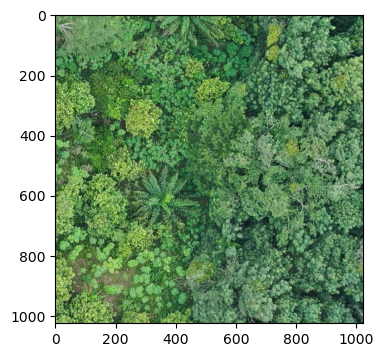

In [23]:
train_arr=np.array(full_train)
for id in train_arr[30:31]:
  img_example=train_images(id[0])
  img=img_example.get_image()
  show(img)

In [24]:
# Dataset
class TreeCountingDataset(Dataset):
  def __init__(self, data,transform=None,dataset_type="train"):
        self.data = data
        self.transform=transform 
        self.dataset_type=dataset_type      
  def __len__(self):
        return len(self.data)
    
  def __getitem__(self, idx):
       
        imagename = self.data.iloc[idx].ImageId
        img=train_images(imagename).get_image()          
        if self.transform:
          img=self.transform(image=img)['image']

        
        if  self.dataset_type=="train":
          label=train_images(imagename).get_label()
          return img, label
        else :
          return img

In [25]:
def get_transforms(img_size):
  data_transforms = {'train': A.Compose([
            A.CLAHE((2,2),p=1),
            A.Resize(img_size,img_size),
            A.ColorJitter (hue=0.03, p=0.5),
            A.GaussianBlur(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.SafeRotate(limit=10, border_mode=0, value=0, p=0.2),
            A.CoarseDropout (max_height=10, max_width=10,max_holes=12,p=0.5),

            A.Normalize(),
            ToTensorV2(),
            
        ]),
        'val': A.Compose([
            A.CLAHE((2,2),p=1),
            A.Resize(img_size,img_size),
            A.Normalize(),
            ToTensorV2(),
            ])}
  return data_transforms

# Define the model

In [26]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    efficientnet_b3 = models.efficientnet_b3(weights="IMAGENET1K_V1")
    print("loading pretrained weights")
    num_features=efficientnet_b3.classifier[1].in_features
    efficientnet_b3.classifier[1]=nn.Linear(num_features,1)
    nn.init.xavier_uniform_(efficientnet_b3.classifier[1].weight)
    self.efficientnet_b3=efficientnet_b3
  def forward(self, x):
    return self.efficientnet_b3(x)
  def freeze(self):
    for p in self.efficientnet_b3.features.parameters():
        p.requires_grad=False
  def unfreeze(self):
    for p in self.efficientnet_b3.parameters():
        p.requires_grad=True

# Training paramaters

In [27]:
seed_all()
params={}
params['img_size']=480
params['batch_size']=16
params['accumulations']=2
params['pretrained']=True
params['lr']=0.001
params['epochs']=25
params['min_epochs']=9

In [28]:
loss_fn=nn.MSELoss()
data_transforms=get_transforms(params['img_size'])

In [29]:
test=pd.read_csv(test_csv_pth)
test_set=TreeCountingDataset(test,data_transforms['val'],'test')
test_set_loader=torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=False)
def predict_test(model,fold):
  preds=[]
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(test_set_loader):
        images=data
        images= images.cuda() if cuda else images
        prediction=model(images)
        preds.append(prediction.item())
  test['Target']=preds
  test_pth='sub_'+str(fold)+'.csv'
  test.to_csv(test_pth,index=False)  


def predict_val(model,val_ids):
    preds=[]
    model.eval()
    val_df=full_train.iloc[val_ids,:].reset_index(drop=True)
    val_subset=TreeCountingDataset(val_df,data_transforms["val"],"train")
    valloader = torch.utils.data.DataLoader(val_subset,batch_size=1,shuffle=False)
    with torch.no_grad():
        for i, data in enumerate(valloader):
            images,labels=data
            images= images.cuda() if cuda else images
            prediction=model(images)
            preds.append(prediction.item())
    full_train.loc[val_ids,'preds']=preds

# Training and testing

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


loading pretrained weights
Fold: 1 Epoch :  1 Train loss = 18.37 val loss = 17.57 lr = 0.001000
Fold: 1 Epoch :  2 Train loss = 11.36 val loss = 15.38 lr = 0.001000
layer unfreezed
Fold: 1 Epoch :  3 Train loss = 4.34 val loss = 4.52 lr = 0.001000
Fold: 1 Epoch :  4 Train loss = 2.92 val loss = 4.59 lr = 0.001000
Fold: 1 Epoch :  5 Train loss = 1.85 val loss = 3.07 lr = 0.001000
Fold: 1 Epoch :  6 Train loss = 1.49 val loss = 2.61 lr = 0.001000
Fold: 1 Epoch :  7 Train loss = 1.33 val loss = 2.52 lr = 0.001000
Fold: 1 Epoch :  8 Train loss = 1.16 val loss = 3.39 lr = 0.001000
Fold: 1 Epoch :  9 Train loss = 1.00 val loss = 2.95 lr = 0.001000
Fold: 1 Epoch : 10 Train loss = 0.99 val loss = 3.56 lr = 0.001000
Fold: 1 Epoch : 11 Train loss = 0.88 val loss = 2.46 lr = 0.001000
Fold: 1 Epoch : 12 Train loss = 0.87 val loss = 2.46 lr = 0.001000
Fold: 1 Epoch : 13 Train loss = 0.72 val loss = 2.41 lr = 0.001000
Fold: 1 Epoch : 14 Train loss = 0.67 val loss = 2.55 lr = 0.001000
Fold: 1 Epoch :

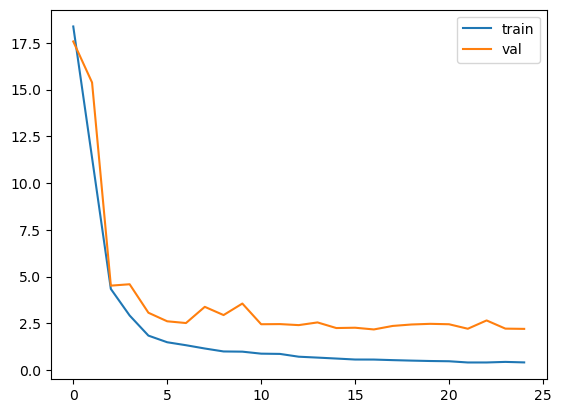

loading pretrained weights
Fold: 2 Epoch :  1 Train loss = 18.47 val loss = 17.02 lr = 0.001000
Fold: 2 Epoch :  2 Train loss = 11.38 val loss = 15.50 lr = 0.001000
layer unfreezed
Fold: 2 Epoch :  3 Train loss = 4.16 val loss = 5.87 lr = 0.001000
Fold: 2 Epoch :  4 Train loss = 2.68 val loss = 2.89 lr = 0.001000
Fold: 2 Epoch :  5 Train loss = 2.10 val loss = 2.87 lr = 0.001000
Fold: 2 Epoch :  6 Train loss = 1.53 val loss = 2.87 lr = 0.001000
Fold: 2 Epoch :  7 Train loss = 1.53 val loss = 2.61 lr = 0.001000
Fold: 2 Epoch :  8 Train loss = 1.27 val loss = 2.94 lr = 0.001000
Fold: 2 Epoch :  9 Train loss = 1.01 val loss = 3.04 lr = 0.001000
Fold: 2 Epoch : 10 Train loss = 0.90 val loss = 2.45 lr = 0.001000
Fold: 2 Epoch : 11 Train loss = 0.83 val loss = 3.04 lr = 0.001000
Fold: 2 Epoch : 12 Train loss = 0.75 val loss = 3.03 lr = 0.001000
Fold: 2 Epoch : 13 Train loss = 0.78 val loss = 2.57 lr = 0.001000
Fold: 2 Epoch : 14 Train loss = 0.70 val loss = 2.36 lr = 0.001000
Fold: 2 Epoch :

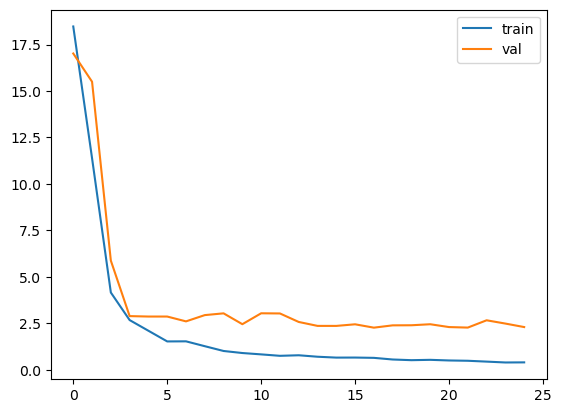

loading pretrained weights
Fold: 3 Epoch :  1 Train loss = 18.51 val loss = 16.64 lr = 0.001000
Fold: 3 Epoch :  2 Train loss = 11.38 val loss = 15.25 lr = 0.001000
layer unfreezed
Fold: 3 Epoch :  3 Train loss = 4.63 val loss = 4.24 lr = 0.001000
Fold: 3 Epoch :  4 Train loss = 2.74 val loss = 4.69 lr = 0.001000
Fold: 3 Epoch :  5 Train loss = 2.04 val loss = 3.34 lr = 0.001000
Fold: 3 Epoch :  6 Train loss = 1.70 val loss = 3.08 lr = 0.001000
Fold: 3 Epoch :  7 Train loss = 1.33 val loss = 2.98 lr = 0.001000
Fold: 3 Epoch :  8 Train loss = 1.25 val loss = 2.64 lr = 0.001000
Fold: 3 Epoch :  9 Train loss = 1.14 val loss = 2.85 lr = 0.001000
Fold: 3 Epoch : 10 Train loss = 0.96 val loss = 3.89 lr = 0.001000
Fold: 3 Epoch : 11 Train loss = 0.97 val loss = 3.01 lr = 0.001000
Fold: 3 Epoch : 12 Train loss = 0.96 val loss = 2.53 lr = 0.001000
Fold: 3 Epoch : 13 Train loss = 0.79 val loss = 2.63 lr = 0.001000
Fold: 3 Epoch : 14 Train loss = 0.70 val loss = 2.36 lr = 0.001000
Fold: 3 Epoch :

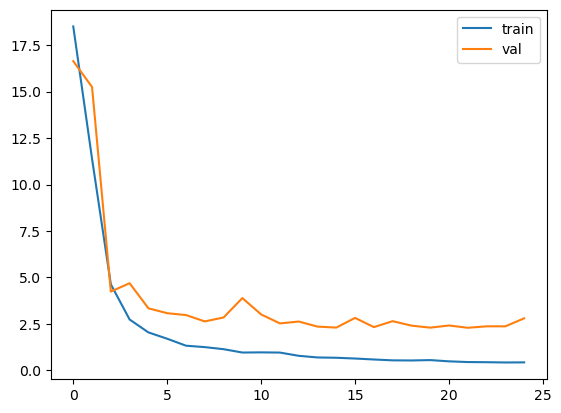

loading pretrained weights
Fold: 4 Epoch :  1 Train loss = 18.26 val loss = 17.27 lr = 0.001000
Fold: 4 Epoch :  2 Train loss = 11.30 val loss = 15.81 lr = 0.001000
layer unfreezed
Fold: 4 Epoch :  3 Train loss = 4.12 val loss = 4.22 lr = 0.001000
Fold: 4 Epoch :  4 Train loss = 2.78 val loss = 6.61 lr = 0.001000
Fold: 4 Epoch :  5 Train loss = 2.20 val loss = 3.09 lr = 0.001000
Fold: 4 Epoch :  6 Train loss = 1.65 val loss = 2.63 lr = 0.001000
Fold: 4 Epoch :  7 Train loss = 1.47 val loss = 3.12 lr = 0.001000
Fold: 4 Epoch :  8 Train loss = 1.30 val loss = 2.96 lr = 0.001000
Fold: 4 Epoch :  9 Train loss = 1.05 val loss = 3.24 lr = 0.001000
Fold: 4 Epoch : 10 Train loss = 0.96 val loss = 2.31 lr = 0.001000
Fold: 4 Epoch : 11 Train loss = 0.90 val loss = 2.98 lr = 0.001000
Fold: 4 Epoch : 12 Train loss = 0.83 val loss = 2.48 lr = 0.001000
Fold: 4 Epoch : 13 Train loss = 0.77 val loss = 2.51 lr = 0.001000
Fold: 4 Epoch : 14 Train loss = 0.68 val loss = 2.25 lr = 0.001000
Fold: 4 Epoch :

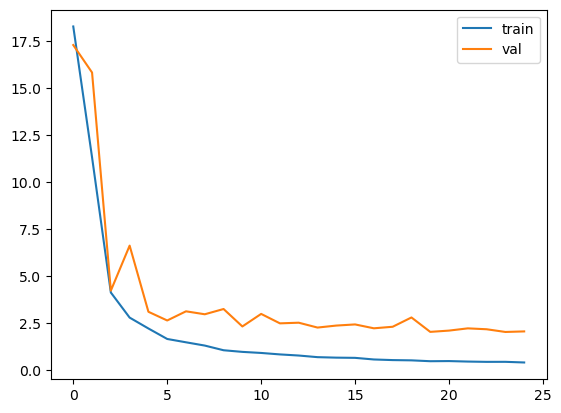

loading pretrained weights
Fold: 5 Epoch :  1 Train loss = 18.48 val loss = 17.09 lr = 0.001000
Fold: 5 Epoch :  2 Train loss = 11.48 val loss = 15.97 lr = 0.001000
layer unfreezed
Fold: 5 Epoch :  3 Train loss = 4.18 val loss = 4.06 lr = 0.001000
Fold: 5 Epoch :  4 Train loss = 2.60 val loss = 5.14 lr = 0.001000
Fold: 5 Epoch :  5 Train loss = 1.94 val loss = 4.00 lr = 0.001000
Fold: 5 Epoch :  6 Train loss = 1.64 val loss = 3.01 lr = 0.001000
Fold: 5 Epoch :  7 Train loss = 1.37 val loss = 2.92 lr = 0.001000
Fold: 5 Epoch :  8 Train loss = 1.13 val loss = 2.62 lr = 0.001000
Fold: 5 Epoch :  9 Train loss = 1.04 val loss = 2.94 lr = 0.001000
Fold: 5 Epoch : 10 Train loss = 0.97 val loss = 3.72 lr = 0.001000
Fold: 5 Epoch : 11 Train loss = 0.80 val loss = 3.26 lr = 0.001000
Fold: 5 Epoch : 12 Train loss = 0.79 val loss = 2.52 lr = 0.001000
Fold: 5 Epoch : 13 Train loss = 0.72 val loss = 2.51 lr = 0.001000
Fold: 5 Epoch : 14 Train loss = 0.71 val loss = 2.34 lr = 0.001000
Fold: 5 Epoch :

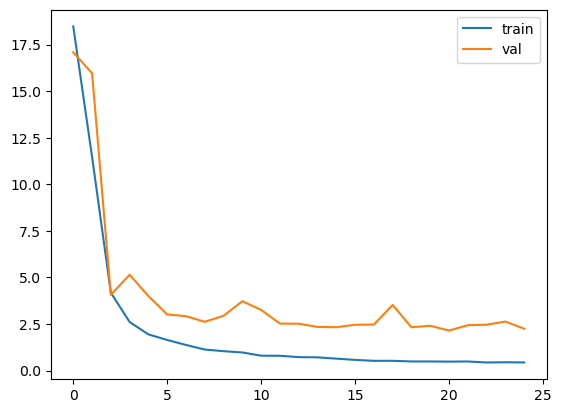

In [30]:
#Full_dataset=TreeCountingDataset(full_train,data_transforms["train"],"train")
full_train["preds"]=0
from sklearn.model_selection import StratifiedKFold

cuda=torch.cuda.is_available()
n_folds=5
skf = StratifiedKFold(n_splits=n_folds,shuffle=True)
indexes=[i for i in range(len(full_train))]
fold_losses=[]
for fold , (train_ids,val_ids) in enumerate( skf.split(indexes,full_train['Target_strat']) ):
  
    train_df=full_train.iloc[train_ids,:].reset_index(drop=True)
    val_df=full_train.iloc[val_ids,:].reset_index(drop=True)

    train_subset = TreeCountingDataset(train_df,data_transforms["train"],"train")
    val_subset=TreeCountingDataset(val_df,data_transforms["val"],"train")
    
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=params['batch_size'],shuffle=True,drop_last=True)
    valloader = torch.utils.data.DataLoader(val_subset,batch_size=params['batch_size'],shuffle=False)

    TreeCountingModel=CNN().cuda() if cuda else CNN()
    TreeCountingModel.freeze()
    optimizer = optim.AdamW(TreeCountingModel.parameters(), lr=params['lr'])
    
    n_iterations=(len(trainloader)//params['accumulations'])*params['epochs']
    scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,n_iterations,params['lr']/300)

    train_losses=[]
    val_losses=[]
    train_samples=0
    j=0
    for e in range(params['epochs']):
        train_cumalitive_loss=0
        TreeCountingModel.train()
        if e+1==3:
            TreeCountingModel.unfreeze()
            print("layer unfreezed")
        for i, data in enumerate(trainloader):
            images,labels=data
            (images,labels)= (images.cuda(),labels.float().cuda()) if cuda else (images,labels.float())
            predictions=TreeCountingModel(images)
            predictions=predictions.view(labels.shape)

            loss=loss_fn(predictions,labels)
            loss.backward()
            if (i+1)%params['accumulations']==0:
                optimizer.step()
                optimizer.zero_grad()
                #scheduler.step()
            train_samples+=images.shape[0]
            train_cumalitive_loss+=loss.item()*images.shape[0]

        train_epoch_loss=np.sqrt( train_cumalitive_loss/train_samples )
        train_losses.append(train_epoch_loss)
        optimizer.zero_grad()

        TreeCountingModel.eval()
        val_cumalitive_loss=0
        with torch.no_grad():
            for i, data in enumerate(valloader):
                images,labels=data
                images,labels=(images.cuda(),labels.float().cuda()) if cuda else (images,labels.float())
                predictions=TreeCountingModel(images)
                predictions=predictions.view(labels.shape)
                loss=loss_fn(predictions,labels)
                val_cumalitive_loss+=loss.item()*images.shape[0]
        val_epoch_loss=np.sqrt( val_cumalitive_loss/len(val_subset) )
        val_losses.append(val_epoch_loss)
        print("Fold: %1d Epoch : %2d Train loss = %4.2f val loss = %4.2f lr = %1.6f"%(fold+1, e+1,train_epoch_loss,val_epoch_loss,scheduler.get_last_lr()[0]))

        if e+1>=params['min_epochs']:
            if val_epoch_loss==min(val_losses[params['min_epochs']-1:]):
                torch.save(TreeCountingModel.state_dict(),model_save_pth)
        if e+1==params['epochs']:
            print("Making predictions")
            TreeCountingModel.load_state_dict( torch.load(model_save_pth) )
            fold_losses.append( min(val_losses[params['min_epochs']-1:]) )
            predict_test(TreeCountingModel,fold+1)
            predict_val(TreeCountingModel,val_ids)
            plt.figure()
            plt.plot(train_losses,label="train")
            plt.plot(val_losses,label="val")
            plt.legend()
            plt.pause(0.2)
            break
      

In [31]:
cv_score=sum(fold_losses)/len(fold_losses)
print("CV_score = %.3f"%( cv_score) )

CV_score = 2.181


In [32]:
test['Target']=0
n_folds=5
for i in range(n_folds):
    sub_pth='sub_'+str(i+1)+'.csv'
    sub=pd.read_csv(sub_pth)
    test['Target']=test['Target']+sub['Target']
test['Target']=test['Target']/n_folds
test['Target']=test['Target'].apply(lambda x : x if x>0 else 0)
sub_name=str(cv_score)[:4]+'.csv'
test.to_csv('final_sub.csv',index=False)

(array([  2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,
          0.,   3.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,
         21.,   0.,   0.,   0.,   0.,  50.,   0.,   0.,   0.,  90.,   0.,
          0.,   0.,   0., 128.,   0.,   0.,   0.,   0., 219.,   0.,   0.,
          0.,   0., 467.,   0.,   0.,   0., 209.,   0.,   0.,   0.,   0.,
        106.,   0.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,   0.,  29.,
          0.,   0.,   0.,  12.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,
          0.,   0.,   4.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.]),
 array([-12.  , -11.79, -11.58, -11.37, -11.16, -10.95, -10.74, -10.53,
        -10.32, -10.11,  -9.9 ,  -9.69,  -9.48,  -9.27,  -9.06,  -8.85,
         -8.64,  -8.43,  -8.22,  -8.01,  -7.8 ,  -7.59,  -7.38,  -7.17,
         -6.96,  -6.75,  -6.54,  -6.33,  -6.12,  -5.91,  -5.7 ,  -5.49,
         -5.28,  -5.07,  -4.86

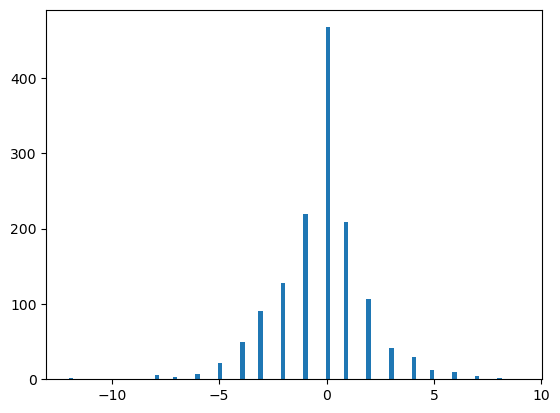

In [33]:
full_train['preds']=full_train['preds'].apply(lambda x : round(x) if x>0 else 0)
diff=np.array (full_train['preds']-full_train['Target'])
plt.hist(diff,bins=100)

In [34]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(full_train['Target'], full_train['preds']))

2.1632585374845976

Id_4x0zh3y93q.png
label: 32.0 prediction 20


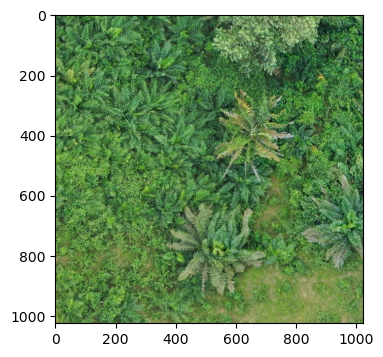

Id_tz74cy4nh9.png
label: 26.0 prediction 15


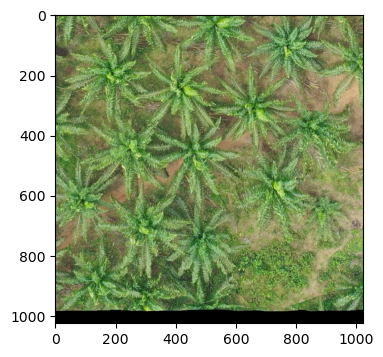

Id_n0ipc9o8el.png
label: 27.0 prediction 15


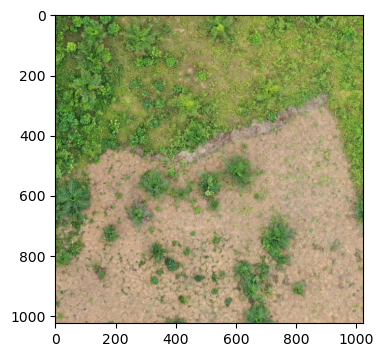

In [35]:
train_arr=np.array(full_train)
for id in train_arr:
  if abs(id[-1]-id[1])>10:
      img_example=train_images(id[0])
      img=img_example.get_image()
      print(id[0])
      print("label:",id[1],"prediction",id[-1])
      show(img)